In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

In [2]:
# Define the RoadDetectionDataset class inheriting from Dataset
class RoadDetectionDataset(Dataset):
    def __init__(self, images_dir, segments_dir, transform=None):
        self.images_dir = images_dir # Directory containing the input images
        self.segments_dir = segments_dir # Directory containing the segmentation masks
        self.image_filenames = os.listdir(images_dir) # List of all image filenames in the images directory
        self.transform = transform # Optional transform to be applied on a sample

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Get the image filename at the specified index
        img_name = self.image_filenames[idx]
        
        # Read the image from the images directory
        image = cv2.imread(os.path.join(self.images_dir, img_name))
        # Convert the image from BGR to RGB color space
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Read the corresponding segmentation mask in grayscale mode
        segment = cv2.imread(os.path.join(self.segments_dir, img_name), cv2.IMREAD_GRAYSCALE)
        
        # Apply transformations if provided
        if self.transform:
            # Apply the transformations to the image and the segmentation mask
            augmented = self.transform(image=image, mask=segment)
            # Extract the transformed image and mask
            image = augmented['image']
            # Add a channel dimension to the mask and normalize its values to be between 0 and 1
            segment = augmented['mask'].unsqueeze(0).float() / 255.0
        
        # Return the transformed image and mask
        return image, segment


In [3]:
# Define transformations using albumentations for data augmentation and preprocessing
transform = A.Compose([
    A.Resize(256, 256), # Resize the images to 256x256 pixels
    A.HorizontalFlip(p=0.5), # Apply horizontal flip with 50% probability
    A.VerticalFlip(p=0.5), # Apply vertical flip with 50% probability
    A.RandomRotate90(p=0.5), # Apply 90 degree rotation with 50% probability
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), # Normalize the images with mean and std deviation of 0.5
    ToTensorV2() # Convert the images and masks to PyTorch tensors
])

# Define the directories for training, validation, and test datasets
train_images_dir = 'dataset/train/images' # Directory for training images
train_segments_dir = 'dataset/train/segments' # Directory for training segmentation masks
val_images_dir = 'dataset/validation/images' # Directory for validation images
val_segments_dir = 'dataset/validation/segments' # Directory for validation segmentation masks
test_images_dir = 'dataset/test/images' # Directory for test images
test_segments_dir = 'dataset/test/segments' # Directory for test segmentation masks

# Create dataset instances for training, validation, and test datasets
train_dataset = RoadDetectionDataset(train_images_dir, train_segments_dir, transform=transform) # Training dataset
val_dataset = RoadDetectionDataset(val_images_dir, val_segments_dir, transform=transform) # Validation dataset
test_dataset = RoadDetectionDataset(test_images_dir, test_segments_dir, transform=transform) # Test dataset

# Create dataloaders for the datasets with a smaller batch size to fit into memory
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4) # DataLoader for training dataset
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4) # DataLoader for validation dataset
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4) # DataLoader for test dataset


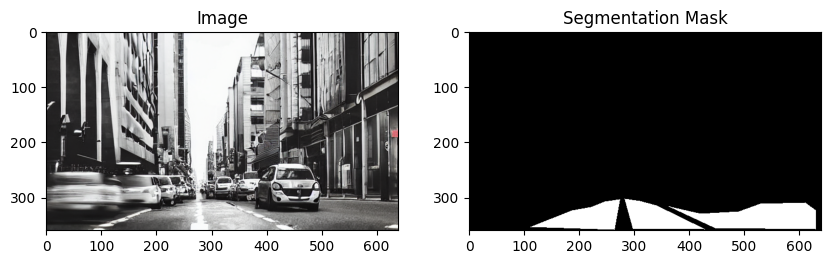

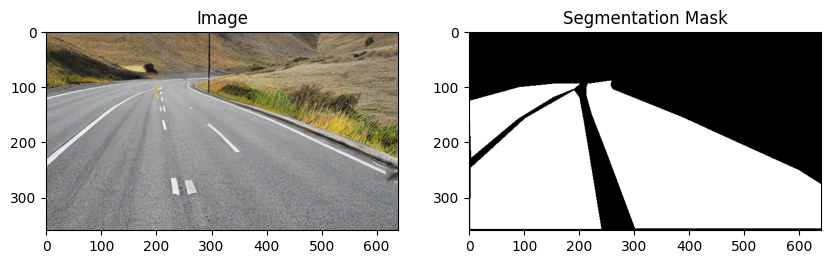

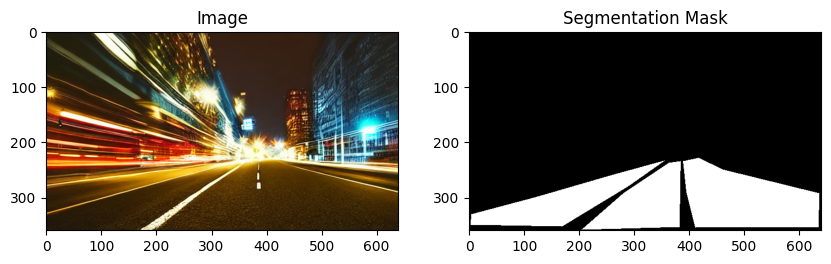

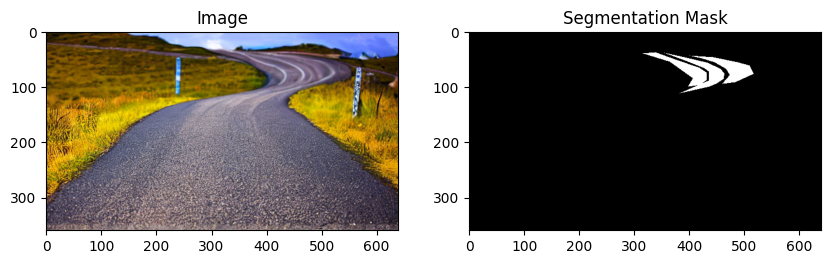

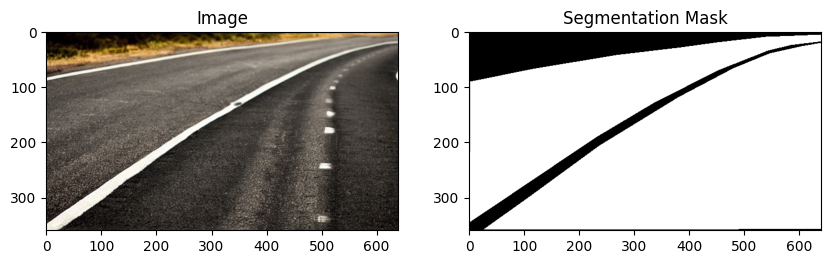

Foreground pixels: 10002810, Total pixels: 36864000
Foreground pixel percentage: 27.13%


In [4]:
# Visualization function
def visualize_dataset(images_dir, segments_dir, idx):
    img_name = os.listdir(images_dir)[idx]
    image = cv2.imread(os.path.join(images_dir, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    segment = cv2.imread(os.path.join(segments_dir, img_name), cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title("Segmentation Mask")
    plt.imshow(segment, cmap='gray')

    plt.show()

# Visualize a few samples from the training set
for i in range(5):
    visualize_dataset(train_images_dir, train_segments_dir, i)

# Evaluate the distribution of the classes in the dataset
def evaluate_class_distribution(segments_dir):
    mask_paths = [os.path.join(segments_dir, fname) for fname in os.listdir(segments_dir)]
    total_pixels = 0
    foreground_pixels = 0

    for path in mask_paths:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        total_pixels += mask.size
        foreground_pixels += np.sum(mask > 0)
    
    print(f"Foreground pixels: {foreground_pixels}, Total pixels: {total_pixels}")
    print(f"Foreground pixel percentage: {foreground_pixels / total_pixels * 100:.2f}%")

# Evaluate the distribution in the training set
evaluate_class_distribution(train_segments_dir)



In [5]:
# Define the UNet model class
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__() # Call the parent class constructor
        # Define the encoder part of the UNet with 5 contracting blocks
        self.encoder1 = self.contracting_block(3, 64) # First contracting block
        self.encoder2 = self.contracting_block(64, 128) # Second contracting block
        self.encoder3 = self.contracting_block(128, 256) # Third contracting block
        self.encoder4 = self.contracting_block(256, 512) # Fourth contracting block
        self.encoder5 = self.contracting_block(512, 1024) # Fifth contracting block

        # Define the decoder part of the UNet with 4 expansive blocks
        self.decoder1 = self.expansive_block(1024, 512) # First expansive block
        self.decoder2 = self.expansive_block(1024, 256) # Second expansive block
        self.decoder3 = self.expansive_block(512, 128) # Third expansive block
        self.decoder4 = self.expansive_block(256, 64) # Fourth expansive block
        
        # Define the final layer to get the desired output shape
        self.final_layer = nn.Conv2d(128, 1, kernel_size=1) # Convolution layer to reduce channel to 1

    # Define a contracting block consisting of two convolutional layers followed by BatchNorm and ReLU
    def contracting_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    # Define an expansive block consisting of two convolutional layers followed by BatchNorm and ReLU
    def expansive_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    # Function to crop and concatenate the upsampled image with the bypassed image from the encoder
    def crop_and_concat(self, upsampled, bypass):
        diffY = bypass.size()[2] - upsampled.size()[2] # Calculate the difference in height
        diffX = bypass.size()[3] - upsampled.size()[3] # Calculate the difference in width
        # Pad the upsampled image to match the size of the bypassed image
        upsampled = F.pad(upsampled, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        return torch.cat((upsampled, bypass), 1) # Concatenate the upsampled image and bypassed image along the channel dimension

    # Define the forward pass of the UNet model
    def forward(self, x):
        e1 = self.encoder1(x) # First encoding block
        e2 = self.encoder2(F.max_pool2d(e1, kernel_size=2, stride=2)) # Second encoding block with max pooling
        e3 = self.encoder3(F.max_pool2d(e2, kernel_size=2, stride=2)) # Third encoding block with max pooling
        e4 = self.encoder4(F.max_pool2d(e3, kernel_size=2, stride=2)) # Fourth encoding block with max pooling
        e5 = self.encoder5(F.max_pool2d(e4, kernel_size=2, stride=2)) # Fifth encoding block with max pooling

        # Decoder blocks with upsampling, concatenation, and expansive blocks
        d1 = self.crop_and_concat(F.interpolate(self.decoder1(F.interpolate(e5, scale_factor=2, mode='bilinear')), scale_factor=2, mode='bilinear'), e4)
        d2 = self.crop_and_concat(F.interpolate(self.decoder2(F.interpolate(d1, scale_factor=2, mode='bilinear')), scale_factor=2, mode='bilinear'), e3)
        d3 = self.crop_and_concat(F.interpolate(self.decoder3(F.interpolate(d2, scale_factor=2, mode='bilinear')), scale_factor=2, mode='bilinear'), e2)
        d4 = self.crop_and_concat(F.interpolate(self.decoder4(F.interpolate(d3, scale_factor=2, mode='bilinear')), scale_factor=2, mode='bilinear'), e1)

        final_output = self.final_layer(d4) # Final output layer to get the segmentation mask
        return final_output # Return the final output

# Instantiate the UNet model
model = UNet()

In [6]:
# Define a function to initialize weights of the model
def weights_init(m):
    if isinstance(m, nn.Conv2d): # If the layer is a convolutional layer
        nn.init.xavier_normal_(m.weight) # Initialize weights using Xavier normal initialization
        if m.bias is not None: # If the layer has a bias term
            nn.init.constant_(m.bias, 0) # Initialize bias to 0
    elif isinstance(m, nn.BatchNorm2d): # If the layer is a batch normalization layer
        nn.init.constant_(m.weight, 1) # Initialize weights to 1
        nn.init.constant_(m.bias, 0) # Initialize bias to 0

# Apply the weights initialization function to the model
model.apply(weights_init)

# Define the Dice loss function class
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__() # Call the parent class constructor
        self.smooth = smooth # Smoothing factor to avoid division by zero

    def forward(self, logits, targets):
        logits = torch.sigmoid(logits) # Apply sigmoid to the logits
        num = targets.size(0) # Get the number of samples in the batch
        logits = logits.view(num, -1) # Flatten the logits
        targets = targets.view(num, -1) # Flatten the targets
        intersection = (logits * targets) # Calculate intersection
        # Calculate Dice coefficient
        dice = (2. * intersection.sum(1) + self.smooth) / (logits.sum(1) + targets.sum(1) + self.smooth)
        return 1 - dice.mean() # Return Dice loss

# Define BCEWithLogitsLoss and DiceLoss as loss functions
criterion_bce = nn.BCEWithLogitsLoss()
criterion_dice = DiceLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Initialize gradient scaler for mixed precision training
scaler = GradScaler()

# Define the training function
def train(model, train_loader, criterion_bce, criterion_dice, optimizer, scaler, device, check_gradients_every_n_epochs=5):
    model.train() # Set the model to training mode
    running_loss = 0.0 # Initialize running loss to 0
    for epoch in range(num_epochs):
        for batch_idx, (images, segments) in enumerate(train_loader):
            images, segments = images.to(device), segments.to(device) # Move data to the specified device
            optimizer.zero_grad() # Zero the parameter gradients
            with autocast(): # Enable mixed precision
                outputs = model(images) # Forward pass
                loss_bce = criterion_bce(outputs, segments) # Calculate BCE loss
                loss_dice = criterion_dice(outputs, segments) # Calculate Dice loss
                loss = loss_bce + loss_dice # Total loss
            scaler.scale(loss).backward() # Backward pass with scaling
            scaler.step(optimizer) # Optimize the parameters
            scaler.update() # Update the scaler
            running_loss += loss.item() # Update running loss
        
        # Check gradients for encoder layers every n epochs
        if (epoch + 1) % check_gradients_every_n_epochs == 0:
            print(f"Epoch {epoch+1}:")
            for name, param in model.named_parameters():
                if param.grad is not None and 'encoder' in name:
                    print(f"Gradients for {name}: {param.grad.abs().mean().item()}")
        
        # Calculate and print the epoch loss
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
        running_loss = 0.0 # Reset running loss for next epoch
    
    return epoch_loss

# Define the device to be used for training (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the specified device
model.to(device)

# Set the number of epochs for training
num_epochs = 50

# Call the training function
epoch_loss = train(model, train_loader, criterion_bce, criterion_dice, optimizer, scaler, device, check_gradients_every_n_epochs=5)

# Save the trained model
torch.save(model.state_dict(), 'unet_model.pth')
print("Model saved successfully!")


Using device: cuda
Epoch 1/50, Loss: 1.766606968641281
Epoch 2/50, Loss: 1.5685651898384094
Epoch 3/50, Loss: 1.4322893679142
Epoch 4/50, Loss: 1.3390835404396058
Epoch 5:
Gradients for encoder1.0.weight: 0.015557647682726383
Gradients for encoder1.0.bias: 5.67827737540938e-06
Gradients for encoder1.1.weight: 0.003372151404619217
Gradients for encoder1.1.bias: 0.0032789267133921385
Gradients for encoder1.3.weight: 0.0032885621767491102
Gradients for encoder1.3.bias: 6.387526809703559e-07
Gradients for encoder1.4.weight: 0.01023684162646532
Gradients for encoder1.4.bias: 0.011859942227602005
Gradients for encoder2.0.weight: 0.0021370304748415947
Gradients for encoder2.0.bias: 3.347252004459733e-07
Gradients for encoder2.1.weight: 0.0016466882079839706
Gradients for encoder2.1.bias: 0.0011917802039533854
Gradients for encoder2.3.weight: 0.0014392843004316092
Gradients for encoder2.3.bias: 2.6178258849540725e-07
Gradients for encoder2.4.weight: 0.0015569684328511357
Gradients for encoder2

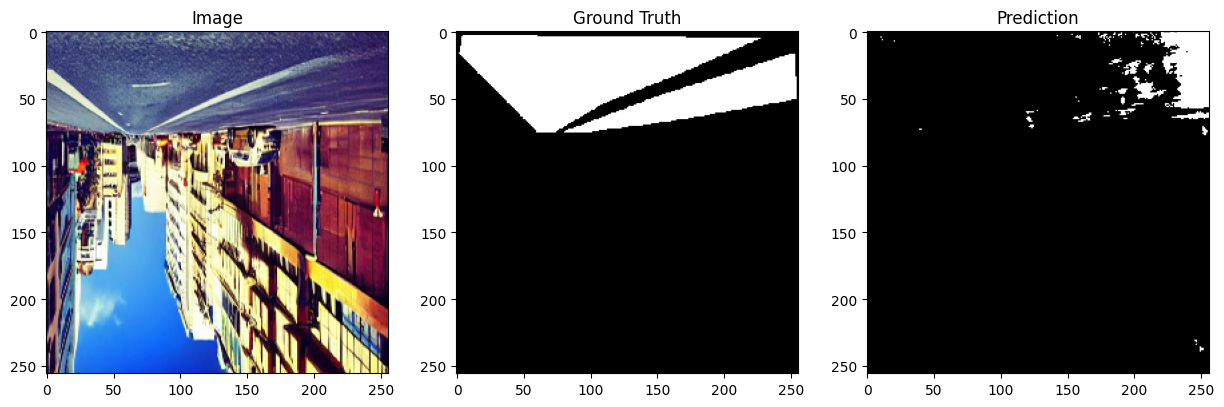

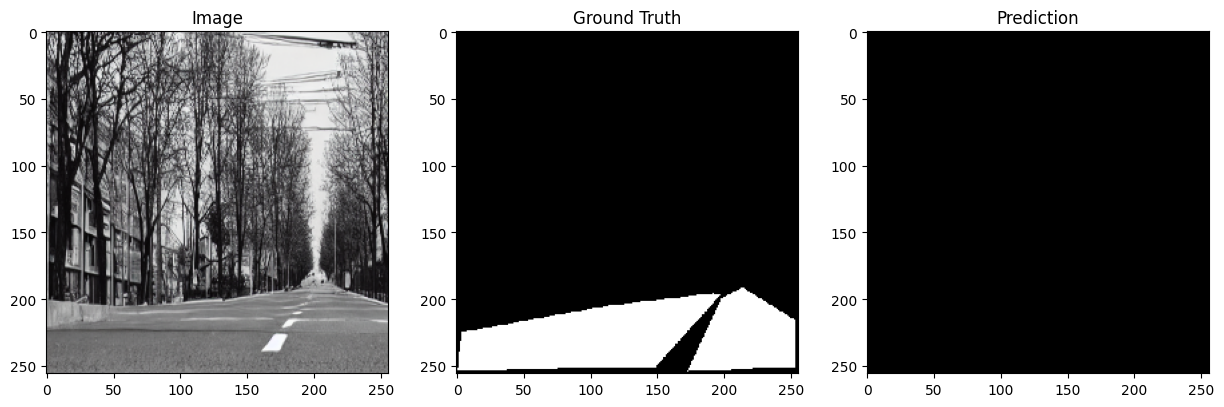

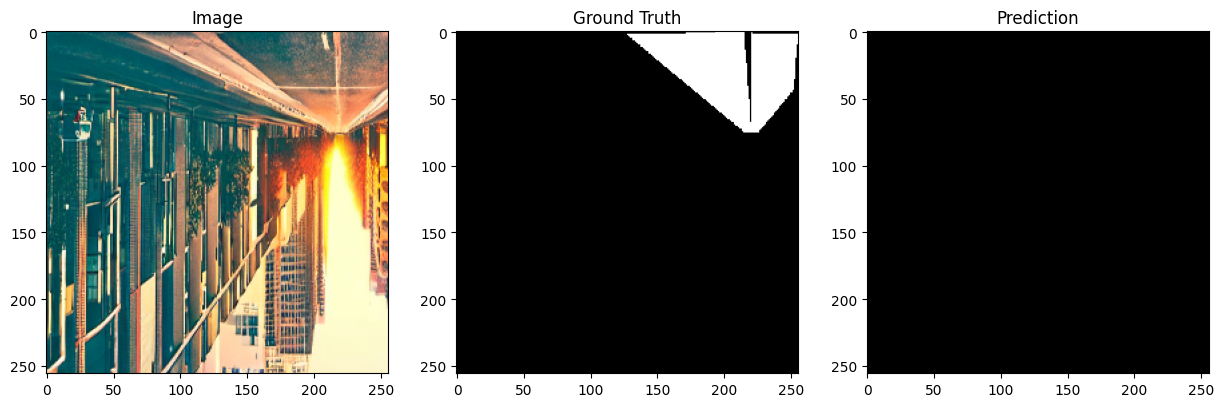

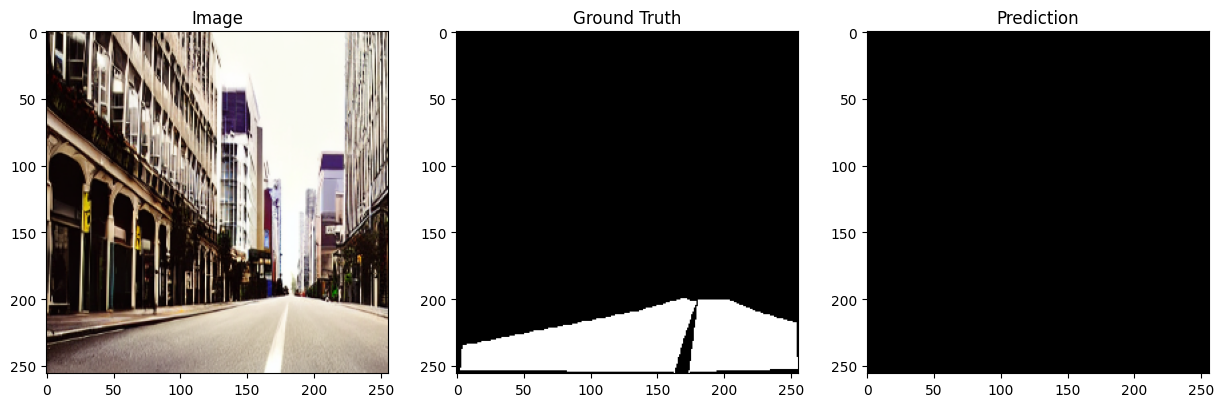

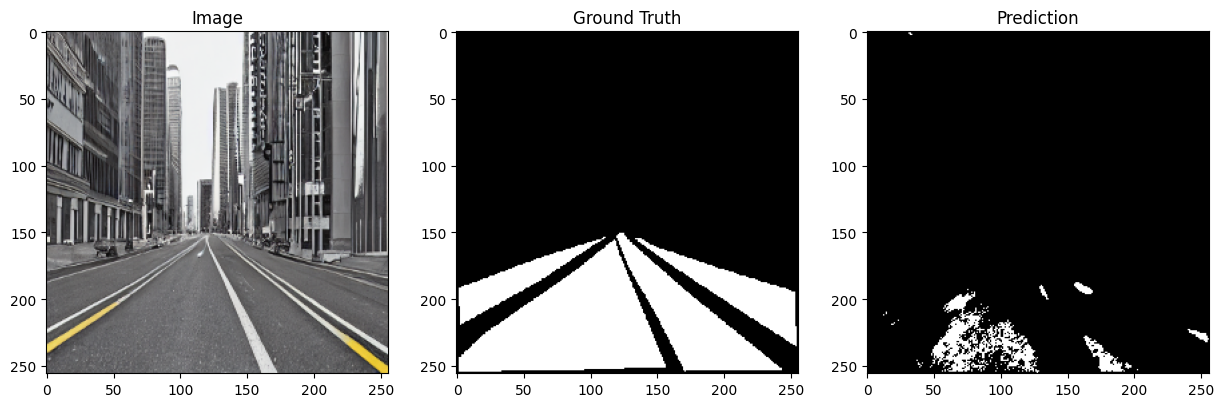

In [7]:
# Function to denormalize images for visualization
def denormalize_image(image):
    image = image * 0.5 + 0.5  # Reverse the normalization: (image * 0.5) + 0.5
    return image

# Visualization of predictions
def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (images, segments) in enumerate(dataloader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = preds > 0.5  # Apply threshold to get binary masks

            for j in range(images.size(0)):
                if i * images.size(0) + j >= num_images:
                    return
                image = images[j].cpu().numpy().transpose(1, 2, 0)
                segment = segments[j].cpu().numpy().squeeze()
                pred = preds[j].squeeze()

                # Denormalize the image
                image = denormalize_image(image)
                # Clip image to [0, 1] range
                image = np.clip(image, 0, 1)

                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.title("Image")
                plt.imshow(image)
                
                plt.subplot(1, 3, 2)
                plt.title("Ground Truth")
                plt.imshow(segment, cmap='gray')
                
                plt.subplot(1, 3, 3)
                plt.title("Prediction")
                plt.imshow(pred, cmap='gray')

                plt.show()

# Visualize some predictions
visualize_predictions(model, val_loader, device)
